# Лабораторная работа №4

_Выполнили: Гуревич Михаил, Трохан Александр и Соловьёв Роман, M33001_

In [1]:
import numpy as np
import seaborn as sns
from sklearn import svm
from sklearn.metrics import mean_squared_error
import sympy as smp
from matplotlib import pyplot as plt

from typing import Literal
import decimal
import warnings

from findCoefs import find


np.random.seed(42)
decimal.getcontext().prec = 10
LEN = 1000
COEFS = find()[0]
X_START = np.array([COEFS[0], COEFS[0], COEFS[0]])

print("Coefficients: ", COEFS)
print("X0: ", X_START)

warnings.filterwarnings("ignore")

Coefficients:  [ 0.          0.54256004 -0.46341769 -0.46572975]
X0:  [0. 0. 0.]


## Реализация алгоритма

Реализуем класс авторегрессионной модели временного ряда $\text{AR}(3)$:

In [2]:
class AR3:
    def __init__(self, coefs: np.ndarray, x_start: np.ndarray, length=LEN):
        if len(coefs) != 4:
            raise ValueError("Wrong number of coefficients.")

        if len(x_start) != 3:
            raise ValueError("Wrong number of first Xs.")

        self.coefs = coefs.copy()
        self.x = np.zeros(length)
        self.x[0] = x_start[0]
        self.x[1] = x_start[1]
        self.x[2] = x_start[2]
        self.eps = np.random.normal(0, 5, length)

    def __str__(self):
        result = ""

        for i in range(len(self.coefs)):
            if self.coefs[i] > 0:
                if (i != 0) and result:
                    result += " + "
                result += f"{self.coefs[i]:.4f} * X_(t-{i})"
            elif self.coefs[i] < 0:
                if (i != 0) and result:
                    result += " "
                result += f"{self.coefs[i]:.4f} * X_(t-{i})"

        return "X_t = " + result

    def _check_stationarity(self):
        """Check if model is stationarity."""

        z = smp.Symbol("z")
        equation_solution = smp.solve(
            smp.Eq(1 - self.coefs[1] * z - self.coefs[2] * z ** 2 - self.coefs[3] * z ** 3, 0))

        return equation_solution

    def _generate_first_values(self, length=LEN):
        """Generate first `length` values of the series."""

        for i in range(3, length):
            self.x[i] = self.coefs[0] \
                + self.coefs[1] * self.x[i - 1] \
                + self.coefs[2] * self.x[i - 2] \
                + self.coefs[3] * self.x[i - 3] \
                + self.eps[i]

    def _delay_vector(self):
        """Create delay vectors."""

        vectors = np.ndarray(shape=(LEN - 3, 3))

        for i in range(2, LEN - 1):
            vector_i = np.array([self.x[i - 2], self.x[i - 1], self.x[i]])
            vectors[i - 2] = vector_i

        self.vectors_train = vectors[:int(0.8 * (LEN - 3))].copy()
        self.last_vec = vectors[int(0.8 * (LEN - 3))].copy()
        self.y_train = self.x[3:int(0.8 * (LEN - 3)) + 3].copy()
        self.y_test = self.x[int(0.8 * (LEN - 3)) + 3:].copy()

    def _get_result(self, model: svm.SVR):
        """Predict series."""

        result = np.zeros(LEN - int(0.8 * (LEN - 3)) - 3)
        vec = self.last_vec.copy()
        for i in range(LEN - int(0.8 * (LEN - 3)) - 3):
            result[i] = model.predict(vec.reshape(1, -1))
            vec[0] = vec[1]
            vec[1] = vec[2]
            vec[2] = result[i]

        return result

    def _predict_linear(self, **model_args):
        """Use linear SVR to predict series."""

        svr_model = svm.SVR(kernel="linear", **model_args, max_iter=100_000).fit(
            self.vectors_train, self.y_train)

        return self._get_result(svr_model)

    def _predict_poly(self, **model_args):
        """Use poly SVR to predict series."""

        svr_model = svm.SVR(kernel="poly", **model_args, max_iter=10_000).fit(
            self.vectors_train, self.y_train)
        
        return self._get_result(svr_model)

    def _predict_rbf(self, **model_args):
        """Use rbf SVR to predict series."""

        svr_model = svm.SVR(kernel="rbf", **model_args).fit(
            self.vectors_train, self.y_train)
        
        return self._get_result(svr_model)

    def _predict_sigmoid(self, **model_args):
        """Use sigmoid SVR to predict series."""

        svr_model = svm.SVR(kernel="sigmoid", **model_args).fit(
            self.vectors_train, self.y_train)
        
        return self._get_result(svr_model)

    def _calc_error(self, res):
        return mean_squared_error(self.y_test, res)

    def _find_best(self, kernel: Literal["linear", "poly", "rbf", "sigmoid"]):
        """Change hyperparams to find best predict model."""

        lowest_error = float("inf")
        best_params = []
        best_predict = None

        if kernel == "linear":
            for C in range(2, 32, 2):
                res = self._predict_linear(C=C / 10)
                if lowest_error == -1 or self._calc_error(res) < lowest_error:
                    lowest_error = self._calc_error(res)
                    best_params = [C / 10]
                    best_predict = res

        elif kernel == "poly":
            for C in range(20, 205, 5):
                for degree in range(2, 5, 1):
                    for coef0 in range(0, 22, 2):
                        gamma = "scale"
                        res = self._predict_poly(
                            C=C / 100, gamma=gamma, coef0=coef0 / 10, degree=degree)
                        if self._calc_error(res) < lowest_error:
                            lowest_error = self._calc_error(res)
                            best_params = [C /100, gamma, coef0 / 10, degree]
                            best_predict = res

        elif kernel == "rbf":
            for C in range(20, 205, 5):
                gamma = "scale"
                res = self._predict_rbf(C=C / 100, gamma=gamma)
                if self._calc_error(res) < lowest_error:
                    lowest_error = self._calc_error(res)
                    best_params = [C / 100, gamma]
                    best_predict = res

        else:  # sigmoid
            for C in range(2, 32, 2):
                for i in range(0, 2, 1):
                    for coef0 in range(-20, 22, 2):
                        gamma = "scale"
                        if i == 1:
                            gamma = "auto"

                        res = self._predict_sigmoid(C=C / 10, gamma=gamma, coef0=coef0 / 10)
                        if self._calc_error(res) < lowest_error:
                            lowest_error = self._calc_error(res)
                            best_params = [C / 10, gamma, coef0 / 10]
                            best_predict = res

        return (lowest_error, best_params, best_predict)

    def show_eps_distribution(self):
        """Show plot of eps distribution."""

        fig = plt.figure()
        sns.kdeplot(self.eps, fill=True, label="Eps")
        plt.xlabel("Eps values", fontsize=16)
        plt.ylabel("Number of values / len", fontsize=16)
        plt.title("The eps distribution density")
        return (1, fig)

    def show_series(self):
        """Show plot of series."""

        fig = plt.figure()
        plt.plot(self.x)
        plt.xlabel("t", fontsize=16)
        plt.ylabel("$x_{t}$", fontsize=16)
        plt.title("Series")
        return (1, fig)

    def show_series_with_good_predict(self):
        """Show plot of series."""

        fig = plt.figure()
        plt.plot(self.y_test, label="true")
        best_rbf_err, best_rbf_param, best_rbf_model = self._find_best("rbf")
        best_sigmoid_err, best_sigmoid_param, best_sigmoid_model = self._find_best(
            "sigmoid")
        plt.plot(best_rbf_model, label="rbf")
        plt.plot(best_sigmoid_model, label="sigmoid")
        plt.xlabel("t", fontsize=16)
        plt.ylabel("$x_{t}$", fontsize=16)
        plt.title("Series")
        plt.legend(loc="lower right")
        return (best_rbf_err, best_rbf_param, best_sigmoid_err, best_sigmoid_param, fig)

    def show_series_with_bad_predict(self):
        """Show plot of series."""

        fig = plt.figure()
        plt.plot(self.y_test, label="true")
        best_poly_err, best_poly_param, best_poly_model = self._find_best(
            "poly")
        best_lin_err, best_lin_param, best_lin_model = self._find_best(
            "linear")
        plt.plot(best_poly_model, label="poly")
        plt.plot(best_lin_model, label="linear")
        plt.xlabel("t", fontsize=16)
        plt.ylabel("$x_{t}$", fontsize=16)
        plt.title("Series")
        plt.legend(loc="lower right")
        return (best_lin_err, best_lin_param, best_poly_err, best_poly_param, fig)

    def process_data(self):
        tmp = self._check_stationarity()
        self._generate_first_values()
        self._delay_vector()
        return tmp

Используя этот класс, реализуем функцию которая будет выводить необходимый анализ цепи Маркова:

In [3]:
def solve(coefs: np.ndarray, x_start: np.ndarray):
    try:
        model = AR3(coefs, x_start)
        print(f"Analyze an AR model:\n{model}\n")

        _, fig = model.show_eps_distribution()

        z_solve = model.process_data()
        print("Solution for the equation 1 - a1 * z - a2 * z^2 - a3 * z^3 = 0:")
        print(f"z0 = {z_solve[0]}")
        print(f"z1 = {z_solve[1]}")
        print(f"z2 = {z_solve[2]}\n")
        
        print("Epsilon distribution:")
        plt.show(fig)

        _, fig1 = model.show_series()
        print("Series:")
        plt.show(fig1)

        rbf_err, rbf_param, sigm_err, sigm_param, fig2 = model.show_series_with_good_predict()
        print("Good predictions:")
        plt.show(fig2)
        print(f"Smallest rbf error: {rbf_err}\nRbf parameters [C]: {rbf_param}\n" + \
              f"Smallest sigmoid error: {sigm_err}\nSigmoid parameters [C, gamma, coef0, degree]: {sigm_param}\n")

        lin_err, lin_param, poly_err, poly_param, fig3 = model.show_series_with_bad_predict()
        print("Bad predictions:")
        plt.show(fig3)
        print(f"Smallest linear error: {lin_err}\nLinear parameters [C]: {lin_param}\n" + \
              f"Smallest poly error: {poly_err}\nPoly parameters [C, gamma, coef0, degree]: {poly_param}\n")
        
    except ValueError as error:
        print(error)

## Тестирование алгоритма

С помощью реализованного алгоритма проанализируем авторегрессионную модель, заданную следующим уравнением:
$$x_{t} = a_{0} + a_{1} \cdot x_{t-1} + a_{2} \cdot x_{t-2} + a_{3} \cdot x_{t-3} + \varepsilon_{t}$$


Analyze an AR model:
X_t = 0.5426 * X_(t-1) -0.4634 * X_(t-2) -0.4657 * X_(t-3)

Solution for the equation 1 - a1 * z - a2 * z^2 - a3 * z^3 = 0:
z0 = -2.06370292210965
z1 = 0.534333652433056 - 0.868868143862681*I
z2 = 0.534333652433056 + 0.868868143862681*I

Epsilon distribution:


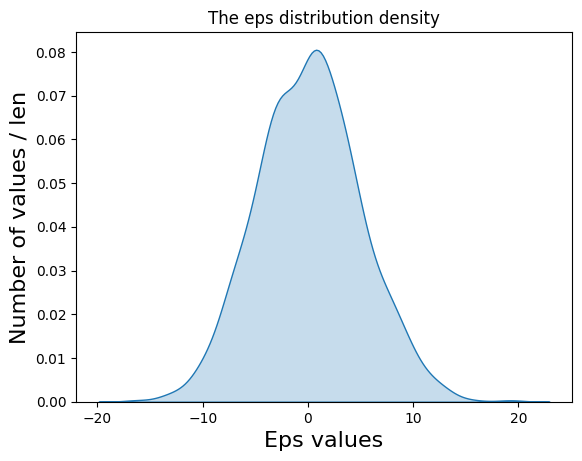

Series:


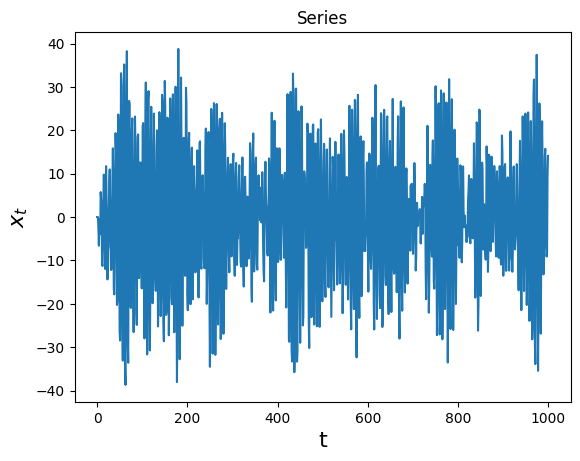

Good predictions:


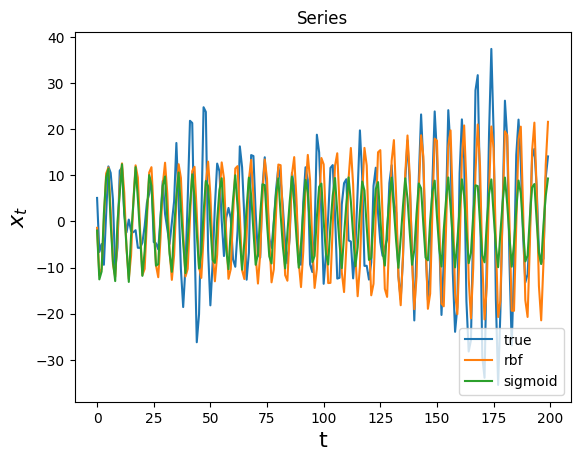

Smallest rbf error: 135.44731479847272
Rbf parameters [C]: [1.7, 'scale']
Smallest sigmoid error: 108.477327119701
Sigmoid parameters [C, gamma, coef0, degree]: [0.8, 'scale', -0.4]

Bad predictions:


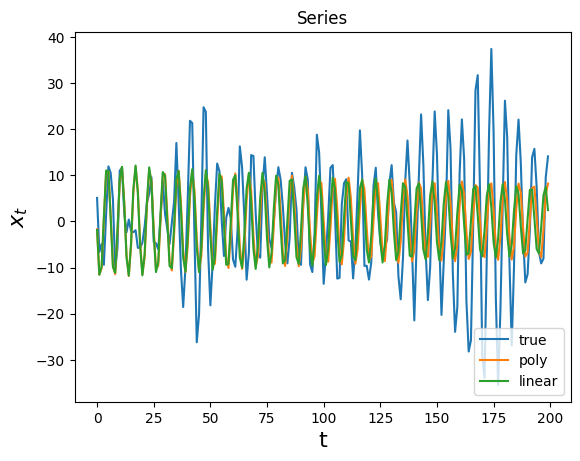

Smallest linear error: 139.47968986611437
Linear parameters [C]: [2.6]
Smallest poly error: 110.6614466667336
Poly parameters [C, gamma, coef0, degree]: [1.1, 'scale', 1.8, 3]



In [4]:
solve(coefs=COEFS, x_start=X_START)